Combine overlays

- todo: make sure no target areas overlap with the AOI nor national boundary

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point, box, LineString
from shapely import intersection, difference, touches, contains
from tqdm.notebook import tqdm
import os
# import glob

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r
target_epsg_verbose = "EPSG:6350"

In [2]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
Aoi = gpd.read_parquet(fn_aoi).rename(columns={'aoi':'aoi_geometry'}).set_geometry('aoi_geometry').set_crs(epsg=target_epsg)

In [3]:
fn_coords = '/Volumes/Extreme SSD/largest_plots/clean_data/coords.parquet'
Coords = gpd.read_parquet(fn_coords).rename(columns={'geometry':'coord_geometry'}).set_geometry('coord_geometry').set_crs(epsg=target_epsg)

In [4]:
fn_water_area_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_area_overlay.parquet'
fn_water_linear_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_linear_overlay.parquet'
fn_rails_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/rails_overlay.parquet'
fn_nation_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/nation_overlay.parquet'

fn_area_out = '/Volumes/Extreme SSD/largest_plots/clean_data/area.csv'

def make_road_fn(i: int)  -> str:
    # These are too large to fit into one table, so load each file independently 
    dir_roads_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/road_overlay'
    fn_out = 'road_overlay_' + str(i) + '.parquet'
    dir_fn_out = os.path.join(dir_roads_overlay, fn_out)
    return dir_fn_out

In [5]:
WaterAreaOverlay = gpd.read_parquet(fn_water_area_overlay).set_geometry('water_area_geometry').set_crs(target_epsg)

In [6]:
# Huge file
WaterLinearOverlay = gpd.read_parquet(fn_water_linear_overlay).set_geometry('water_linear_geometry').set_crs(target_epsg)

In [7]:
RailsOverlay = gpd.read_parquet(fn_rails_overlay).set_geometry('rail_geometry').set_crs(target_epsg)

In [8]:
NationOverlay = gpd.read_parquet(fn_nation_overlay).set_geometry('nation_geometry').set_crs(target_epsg)

In [104]:
# i = 150
best_tract_list = []
for i in tqdm(Aoi.index):
    # Note the coordinates of the target point
    
    # areas that are potentially valid
    coord_observation = Coords.loc[[i]]
    aoi_observation = Aoi.loc[[i]]
    nation_observation = NationOverlay.loc[[i]]
    
    # obstructive areas
    water_linear_observation = WaterLinearOverlay.loc[[i]]
    water_area_observation = WaterAreaOverlay.loc[[i]]
    rail_observation = RailsOverlay.loc[[i]]
    road_observation = gpd.read_parquet(make_road_fn(i)).set_geometry('road_geometry').set_crs(target_epsg)

    # Find intersection between the area of interest and the national coastline
    potential = gpd.overlay(aoi_observation, nation_observation, how='intersection', keep_geom_type=True, make_valid=True)
    
    # Collect all obstructions, flatten them into one layer
    obstruction_series = pd.concat([
        water_linear_observation.rename(columns={'water_linear_geometry':'geometry'}),
        water_area_observation.rename(columns={'water_area_geometry':'geometry'}),
        rail_observation.rename(columns={'rail_geometry':'geometry'}),
        road_observation.rename(columns={'road_geometry':'geometry'})
    ])
    obstruction = gpd.GeoDataFrame(obstruction_series).dissolve()
    
    # remove obstructions from potential
    remaining_potential = potential.difference(obstruction)
    ExplodedRemainingPotential = gpd.GeoDataFrame({'geometry':list(remaining_potential.loc[0].geoms)}, crs=target_epsg_verbose)
    
    # Find closest area to point
    DistanceOfRemainingPotentialsToCoords = gpd.sjoin_nearest(ExplodedRemainingPotential, coord_observation, 
                                                              distance_col="distance", lsuffix="remaining_potential", 
                                                              rsuffix="coord", how='left', exclusive=False)
    
    # Save the results
    BestTract = DistanceOfRemainingPotentialsToCoords.sort_values('distance', ascending=True).head(1)[['geometry', 'distance']]
    BestTract['aoi_index'] = i
    BestTract = BestTract.set_index('aoi_index')
    best_tract_list.append(BestTract)

IndentationError: unexpected indent (2704103306.py, line 3)

<Axes: >

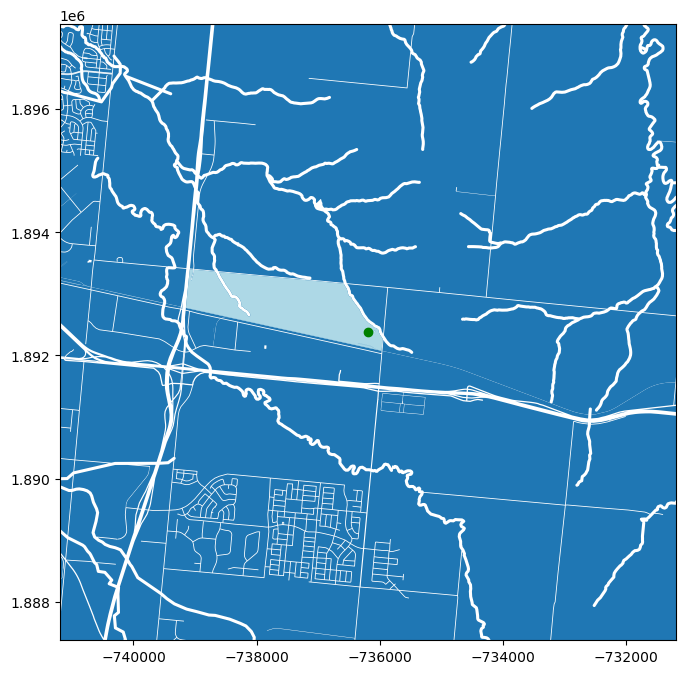

In [95]:
# QC for any given files from the above for-loop
fig, ax = plt.subplots(figsize=(8, 8))

minx, miny, maxx, maxy = coord_observation.buffer(distance=5*1e3).bounds.iloc[0].tolist()
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

ExplodedRemainingPotential.plot(ax=ax)
DistanceOfRemainingPotentialsToCoords.sort_values('distance').head(1).plot(ax=ax, color='lightblue')
coord_observation.plot(ax=ax, color='green')

In [17]:
does_exploded_obstructions_contain_coords = ExplodedObstructions.contains(coord_observation)

/var/folders/zh/p6wj0vfs3qq684w4b1m0_tvr0000gn/T/ipykernel_33303/3580714864.py:1: UserWarning: The indices of the two GeoSeries are different.
  does_exploded_obstructions_contain_coords = ExplodedObstructions.contains(coord_observation)


In [68]:
gpd.GeoDataFrame({'geometry':list(obstruction.geoms)}, crs=target_epsg_verbose)

AttributeError: 'GeoDataFrame' object has no attribute 'geoms'

In [ ]:
target_area_dict = {}
valid_shape_dict = {}  # as qc, make sure no target areas overlap with the valid shape areas

for i in tqdm(Aoi.index):
    
    # Note the coordinates of the target point
    target_coord = Coords.loc[[i]]
    
    # valid ground is the intersection of AOI and nation
    valid_shape = intersection(Aoi.loc[i, 'geometry'], NationOverlay.loc[i, 'geometry'])
    
    # obstruction shape is the intersection of all boundaries
    obstruction_series = gpd.GeoSeries(
        pd.concat([
            WaterAreaOverlay.loc[i],
            WaterLinearOverlay.loc[i],
            RoadsOverlay.loc[i], 
            RailsOverlay.loc[i]
        ])
    )
    obstruction_shape = obstruction_series.unary_union
    
    # Find the valid ground that is not covered by obstructions. 
    # Store this as an exploded table (ie one row per polygon, rather than as a single multipolygon)
    # Returns the part of geometry A that does not intersect with geometry B.
    valid_intersection = difference(valid_shape, obstruction_shape)
    ValidIntersection = gpd.GeoDataFrame({'geometry':list(valid_intersection.geoms)}, crs=target_epsg_verbose)
    
    # Find the area that contains the target coordinate
    TargetArea = gpd.sjoin(left_df=ValidIntersection, right_df=target_coord, how='inner', predicate='contains')[['geometry']]

    # Store results
    valid_shape_dict[i] = valid_shape  # For QC
    target_area_dict[i] = TargetArea

  0%|          | 0/56 [00:00<?, ?it/s]

In [15]:
target_area_dict.keys() == valid_shape_dict.keys()

True

In [16]:
[k for k in target_area_dict.keys()] == Aoi.index.to_list()

True

In [17]:
[k for k in target_area_dict.keys()] == Aoi.index.to_list()

True

In [18]:
contains_dict = {}
touches_dict = {}
area_dict = {}

errors_list = []
for i in valid_shape_dict.keys():
    try:
        v = valid_shape_dict[i]
        t = target_area_dict[i].reset_index(drop=True).loc[0, 'geometry']
        
        area_dict[i] = target_area_dict[i].reset_index(drop=True).loc[0, 'geometry'].area
        contains_dict[i] = contains(v, t) 
        touches_dict[i] = touches(v, t)
        
    except:
        errors_list.append(i)
        
print(errors_list)

[16, 46]


In [19]:
# Do all of the target areas contain the coordinates?
all(contains_dict.values())

True

In [20]:
# Do any of the target areas touch the border of the AOI?
any(touches_dict.values())

False

Look at the problem areas-- both of them are very close to rivers

<Axes: >

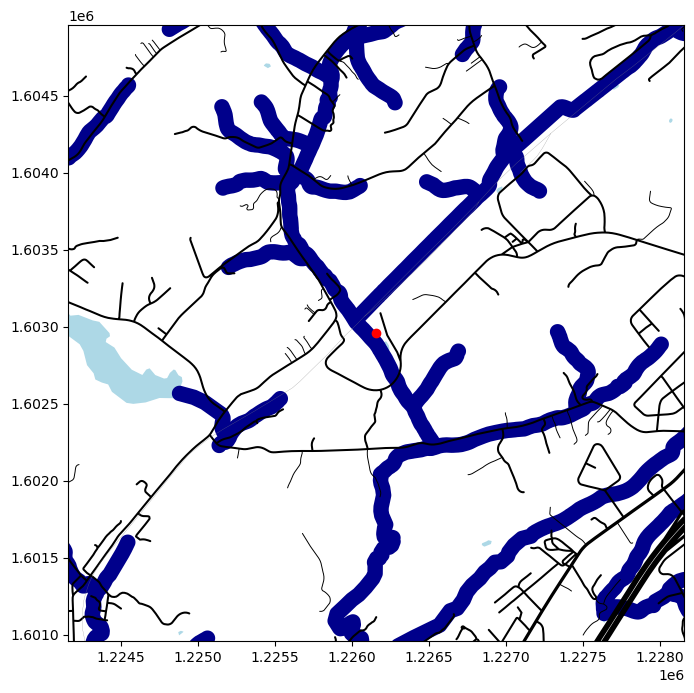

In [21]:
i = 46

coord = Coords.loc[[i]]
x, y, nonsense_x, nonsense_y = coord.loc[i, 'geometry'].bounds


d = (1e3) * 2
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim([x - d, x + d])
ax.set_ylim([y - d, y + d])

WaterAreaOverlay.loc[[i]].plot(ax=ax, color='lightblue')
WaterLinearOverlay.loc[[i]].plot(ax=ax, color='darkblue')
RoadsOverlay.loc[[i]].plot(ax=ax, color='black')
RailsOverlay.loc[[i]].plot(ax=ax, color='grey')
TargetArea.plot(ax=ax, color='pink')
coord.plot(ax=ax, color='red')

<Axes: >

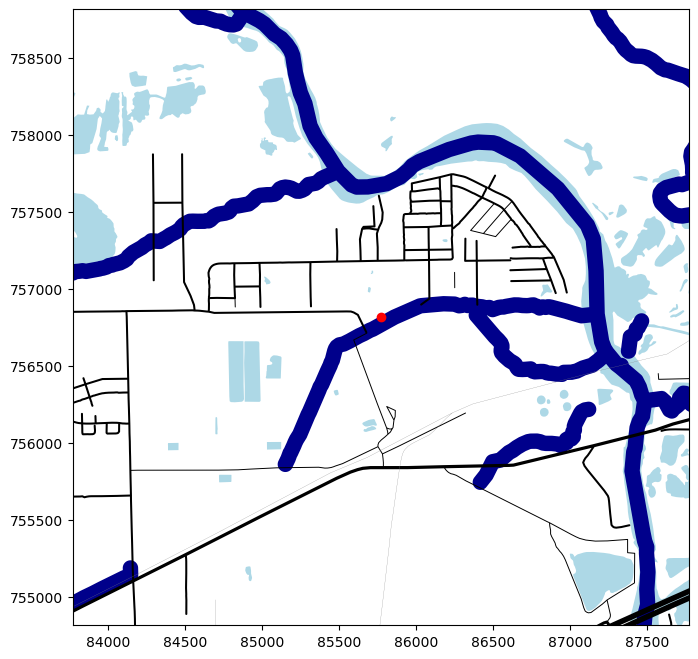

In [22]:
i = 16

coord = Coords.loc[[i]]
x, y, nonsense_x, nonsense_y = coord.loc[i, 'geometry'].bounds


d = (1e3) * 2
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim([x - d, x + d])
ax.set_ylim([y - d, y + d])

WaterAreaOverlay.loc[[i]].plot(ax=ax, color='lightblue')
WaterLinearOverlay.loc[[i]].plot(ax=ax, color='darkblue')
RoadsOverlay.loc[[i]].plot(ax=ax, color='black')
RailsOverlay.loc[[i]].plot(ax=ax, color='grey')
TargetArea.plot(ax=ax, color='pink')
coord.plot(ax=ax, color='red')

# Find area of each target area

In [125]:
index_list = []
area_list = []
for k in area_dict:
    index_list.append(k)
    area_list.append( area_dict[k] )

Area = pd.DataFrame(area_list, columns=['area_m2'], index=index_list)
# Area['area_km2'] = Area['area_m2'] / 1e3
Area = Area.round(1)
Area.head()

,area_m2,area_km2
0,654240.5,654.2
1,815613.5,815.6
2,887745.1,887.7
3,9273697.8,9273.7
4,8260668.3,8260.7


In [137]:
Coords.merge(Area, how='left', left_index=True, right_index=True, validate='1:1').to_csv(fn_area_out)